# Introducing txtai

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

Embeddings databases are a union of vector indexes (sparse and dense), graph networks and relational databases. This enables vector search with SQL, topic modeling, retrieval augmented generation and more.

Embeddings databases can stand on their own and/or serve as a powerful knowledge source for large language model (LLM) prompts.

The following is a summary of key features:

- 🔎 Vector search with SQL, object storage, topic modeling, graph analysis and multimodal indexing
- 📄 Create embeddings for text, documents, audio, images and video
- 💡 Pipelines powered by language models that run LLM prompts, question-answering, labeling, transcription, translation, summarization and more
- ↪️️ Workflows to join pipelines together and aggregate business logic. txtai processes can be simple microservices or multi-model workflows.
- ⚙️ Build with Python or YAML. API bindings available for [JavaScript](https://github.com/neuml/txtai.js), [Java](https://github.com/neuml/txtai.java), [Rust](https://github.com/neuml/txtai.rs) and [Go](https://github.com/neuml/txtai.go).
- ☁️ Run local or scale out with container orchestration

txtai is built with Python 3.8+, [Hugging Face Transformers](https://github.com/huggingface/transformers), [Sentence Transformers](https://github.com/UKPLab/sentence-transformers) and [FastAPI](https://github.com/tiangolo/fastapi). txtai is open-source under an Apache 2.0 license.

# Install dependencies

Install `txtai` and all dependencies.

In [1]:
%%capture
!pip install git+https://github.com/neuml/txtai

# Install translation pipeline dependencies for later examples
!pip install sentencepiece sacremoses fasttext

# Semantic search

Embeddings databases are the engine that delivers semantic search. Data is transformed into embeddings vectors where similar concepts will produce similar vectors. Indexes both large and small are built with these vectors. The indexes are used to find results that have the same meaning, not necessarily the same keywords.

The basic use case for an embeddings database is building an approximate nearest neighbor (ANN) index for semantic search. The following example indexes a small number of text entries to demonstrate the value of semantic search.


In [2]:
%%capture

from txtai import Embeddings

# Works with a list, dataset or generator
data = [
  "US tops 5 million confirmed virus cases",
  "Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg",
  "Beijing mobilises invasion craft along coast as Taiwan tensions escalate",
  "The National Park Service warns against sacrificing slower friends in a bear attack",
  "Maine man wins $1M from $25 lottery ticket",
  "Make huge profits without work, earn up to $100,000 a day"
]

# Create an embeddings
embeddings = Embeddings(path="sentence-transformers/nli-mpnet-base-v2")

In [3]:
# Create an index for the list of text
embeddings.index(data)

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

# Run an embeddings search for each query
for query in ("feel good story", "climate change", "public health story", "war", "wildlife", "asia", "lucky", "dishonest junk"):
  # Extract uid of first result
  # search result format: (uid, score)
  uid = embeddings.search(query, 1)[0][0]

  # Print text
  print("%-20s %s" % (query, data[uid]))

Query                Best Match
--------------------------------------------------
feel good story      Maine man wins $1M from $25 lottery ticket
climate change       Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg
public health story  US tops 5 million confirmed virus cases
war                  Beijing mobilises invasion craft along coast as Taiwan tensions escalate
wildlife             The National Park Service warns against sacrificing slower friends in a bear attack
asia                 Beijing mobilises invasion craft along coast as Taiwan tensions escalate
lucky                Maine man wins $1M from $25 lottery ticket
dishonest junk       Make huge profits without work, earn up to $100,000 a day


The example above shows that for all of the queries, the query text isn’t in the data. This is the true power of transformers models over token based search. What you get out of the box is 🔥🔥🔥!

# Updates and deletes

Updates and deletes are supported for embeddings. The upsert operation will insert new data and update existing data

The following section runs a query, then updates a value changing the top result and finally deletes the updated value to revert back to the original query results.

In [4]:
# Run initial query
uid = embeddings.search("feel good story", 1)[0][0]
print("Initial: ", data[uid])

# Create a copy of data to modify
udata = data.copy()

# Update data
udata[0] = "See it: baby panda born"
embeddings.upsert([(0, udata[0], None)])

uid = embeddings.search("feel good story", 1)[0][0]
print("After update: ", udata[uid])

# Remove record just added from index
embeddings.delete([0])

# Ensure value matches previous value
uid = embeddings.search("feel good story", 1)[0][0]
print("After delete: ", udata[uid])

Initial:  Maine man wins $1M from $25 lottery ticket
After update:  See it: baby panda born
After delete:  Maine man wins $1M from $25 lottery ticket


# Persistence

Embeddings can be saved to storage and reloaded.

In [5]:
embeddings.save("index")

embeddings = Embeddings()
embeddings.load("index")

uid = embeddings.search("climate change", 1)[0][0]
print(data[uid])

Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg


# Hybrid search

While dense vector indexes are by far the best option for semantic search systems, sparse keyword indexes can still add value. There may be cases where finding an exact match is important.

Hybrid search combines the results from sparse and dense vector indexes for the best of both worlds.

In [6]:
# Create an embeddings
embeddings = Embeddings(hybrid=True, path="sentence-transformers/nli-mpnet-base-v2")

# Create an index for the list of text
embeddings.index(data)

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

# Run an embeddings search for each query
for query in ("feel good story", "climate change", "public health story", "war", "wildlife", "asia", "lucky", "dishonest junk"):
  # Extract uid of first result
  # search result format: (uid, score)
  uid = embeddings.search(query, 1)[0][0]

  # Print text
  print("%-20s %s" % (query, data[uid]))

Query                Best Match
--------------------------------------------------
feel good story      Maine man wins $1M from $25 lottery ticket
climate change       Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg
public health story  US tops 5 million confirmed virus cases
war                  Beijing mobilises invasion craft along coast as Taiwan tensions escalate
wildlife             The National Park Service warns against sacrificing slower friends in a bear attack
asia                 Beijing mobilises invasion craft along coast as Taiwan tensions escalate
lucky                Maine man wins $1M from $25 lottery ticket
dishonest junk       Make huge profits without work, earn up to $100,000 a day


Same results as with semantic search. Let's run the same example with just a keyword index to view those results.

In [7]:
# Create an embeddings
embeddings = Embeddings(keyword=True)

# Create an index for the list of text
embeddings.index(data)

print(embeddings.search("feel good story"))
print(embeddings.search("lottery"))

[]
[(4, 0.5234998733628726)]


See that when the embeddings instance only uses a keyword index, it can't find semantic matches, only keyword matches.

# Content storage

Up to this point, all the examples are referencing the original data array to retrieve the input text. This works fine for a demo but what if you have millions of documents? In this case, the text needs to be retrieved from an external datastore using the id.

Content storage adds an associated database (i.e. SQLite, DuckDB) that stores associated metadata with the vector index. The document text, additional metadata and additional objects can be stored and retrieved right alongside the indexed vectors.

In [8]:
# Create embeddings with content enabled. The default behavior is to only store indexed vectors.
embeddings = Embeddings(path="sentence-transformers/nli-mpnet-base-v2", content=True, objects=True)

# Create an index for the list of text
embeddings.index(data)

print(embeddings.search("feel good story", 1)[0]["text"])

Maine man wins $1M from $25 lottery ticket


The only change above is setting the *content* flag to True. This enables storing text and metadata content (if provided) alongside the index. Note how the text is pulled right from the query result!

Let's add some metadata.

# Query with SQL

When content is enabled, the entire dictionary is stored and can be queried. In addition to vector queries, txtai accepts SQL queries. This enables combined queries using both a vector index and content stored in a database backend.

In [9]:
# Create an index for the list of text
embeddings.index([{"text": text, "length": len(text)} for text in data])

# Filter by score
print(embeddings.search("select text, score from txtai where similar('hiking danger') and score >= 0.15"))

# Filter by metadata field 'length'
print(embeddings.search("select text, length, score from txtai where similar('feel good story') and score >= 0.05 and length >= 40"))

# Run aggregate queries
print(embeddings.search("select count(*), min(length), max(length), sum(length) from txtai"))

[{'text': 'The National Park Service warns against sacrificing slower friends in a bear attack', 'score': 0.3151373565196991}]
[{'text': 'Maine man wins $1M from $25 lottery ticket', 'length': 42, 'score': 0.08329029381275177}]
[{'count(*)': 6, 'min(length)': 39, 'max(length)': 94, 'sum(length)': 387}]


This example above adds a simple additional field, text length.

Note the second query is filtering on the metadata field length along with a `similar` query clause. This gives a great blend of vector search with traditional filtering to help identify the best results.

# Object storage

In addition to metadata, binary content can also be associated with documents. The example below downloads an image, upserts it along with associated text into the embeddings index.

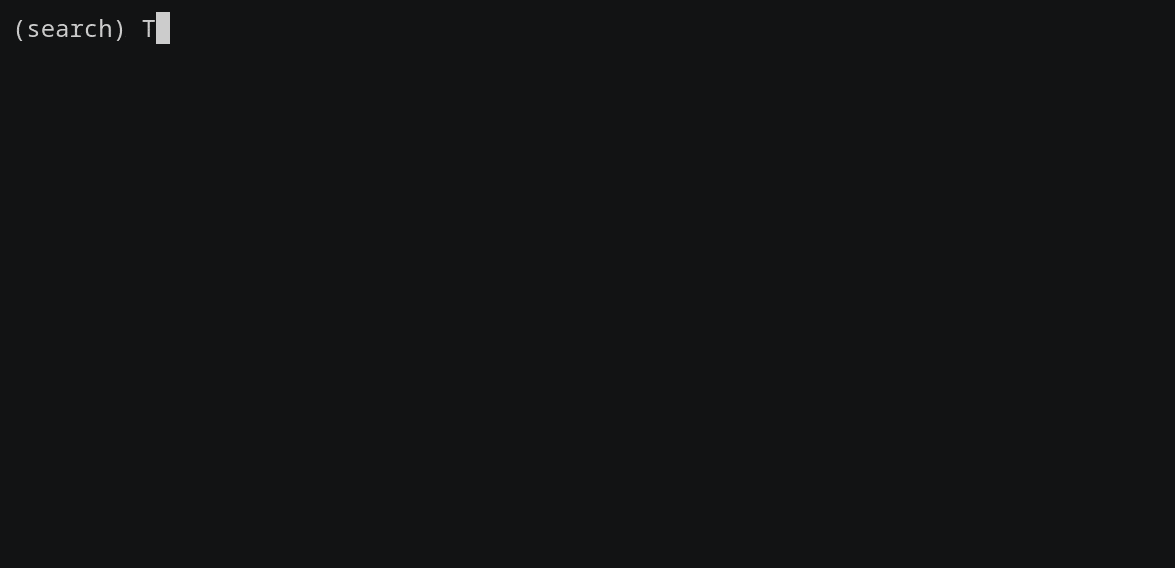

In [10]:
import urllib

from IPython.display import Image

# Get an image
request = urllib.request.urlopen("https://raw.githubusercontent.com/neuml/txtai/master/demo.gif")

# Upsert new record having both text and an object
embeddings.upsert([("txtai", {"text": "txtai executes machine-learning workflows to transform data and build AI-powered semantic search applications.", "object": request.read()}, None)])

# Query txtai for the most similar result to "machine learning" and get associated object
result = embeddings.search("select object from txtai where similar('machine learning') limit 1")[0]["object"]

# Display image
Image(result.getvalue(), width=600)

# Topic modeling

Topic modeling is enabled via semantic graphs. Semantic graphs, also known as knowledge graphs or semantic networks, build a graph network with semantic relationships connecting the nodes. In txtai, they can take advantage of the relationships inherently learned within an embeddings index.

In [11]:
# Create embeddings with a graph index
embeddings = Embeddings(
  path="sentence-transformers/nli-mpnet-base-v2",
  content=True,
  functions=[
    {"name": "graph", "function": "graph.attribute"},
  ],
  expressions=[
    {"name": "category", "expression": "graph(indexid, 'category')"},
    {"name": "topic", "expression": "graph(indexid, 'topic')"},
  ],
  graph={
    "topics": {
      "categories": ["health", "climate", "finance", "world politics"]
    }
  }
)

embeddings.index(data)
embeddings.search("select topic, category, text from txtai")


[{'topic': 'us_virus_5_million',
  'category': 'health',
  'text': 'US tops 5 million confirmed virus cases'},
 {'topic': 'manhattan_collapsed_last_iceberg',
  'category': 'climate',
  'text': "Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg"},
 {'topic': 'escalate_beijing_invasion_mobilises',
  'category': 'world politics',
  'text': 'Beijing mobilises invasion craft along coast as Taiwan tensions escalate'}]

When a graph index is enabled, topics are assigned to each of the entries in the embeddings instance. Topics are dynamically created using a sparse index over graph nodes grouped by [community detection algorithms](https://en.wikipedia.org/wiki/Community_structure).

Topic categories are also be derived as shown above.

# Subindexes

Subindexes can be configured for an embeddings. A single embeddings instance can have multiple subindexes each with different configurations.

We'll build an embeddings index having both a keyword and dense index to demonstrate.

In [12]:
# Create embeddings with subindexes
embeddings = Embeddings(
  content=True,
  defaults=False,
  indexes={
    "keyword": {
      "keyword": True
    },
    "dense": {
      "path": "sentence-transformers/nli-mpnet-base-v2"
    }
  }
)
embeddings.index(data)

In [ ]:
embeddings.search("feel good story", limit=1, index="keyword")

[]

In [13]:
embeddings.search("feel good story", limit=1, index="dense")

[{'id': '4',
  'text': 'Maine man wins $1M from $25 lottery ticket',
  'score': 0.08329029381275177}]

Once again, this example demonstrates the difference between keyword and semantic search. The first search call uses the defined keyword index, the second uses the dense vector index.

# LLM orchestration

txtai is an all-in-one embeddings database. It is the only vector database that also supports sparse indexes, graph networks and relational databases with inline SQL support. In addition to this, txtai has support for LLM orchestration.

The [extractor pipeline](https://neuml.github.io/txtai/pipeline/text/extractor/) is txtai's spin on retrieval augmented generation (RAG). This pipeline extracts knowledge from content by joining a prompt, context data store and generative model together.

The following example shows how a large language model (LLM) can use an embeddings database for context.

In [14]:
import torch
from txtai.pipeline import Extractor

def prompt(question):
  return [{
    "query": question,
    "question": f"""
Answer the following question using the context below.
Question: {question}
Context:
"""
}]

# Create embeddings
embeddings = Embeddings(path="sentence-transformers/nli-mpnet-base-v2", content=True, autoid="uuid5")

# Create an index for the list of text
embeddings.index(data)

# Create and run extractor instance
extractor = Extractor(embeddings, "google/flan-t5-large", torch_dtype=torch.bfloat16, output="reference")
extractor(prompt("What country is having issues with climate change?"))[0]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

{'answer': 'Canada', 'reference': 'da633124-33ff-58d6-8ecb-14f7a44c042a'}

The logic above first builds an embeddings index. It then loads a LLM and uses the embeddings index to drive a LLM prompt.

The extractor pipeline can optionally return a reference to the id of the best matching record with the answer. That id can be used to resolve the full answer reference. Note that the embeddings above used an [uuid autosequence](https://neuml.github.io/txtai/embeddings/configuration/general/#autoid).

In [15]:
uid = extractor(prompt("What country is having issues with climate change?"))[0]["reference"]
embeddings.search(f"select id, text from txtai where id = '{uid}'")

[{'id': 'da633124-33ff-58d6-8ecb-14f7a44c042a',
  'text': "Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg"}]

LLM inference can also be run standalone.

In [16]:
from txtai.pipeline import LLM

llm = LLM("google/flan-t5-large", torch_dtype=torch.bfloat16)
llm("Where is one place you'd go in Washington, DC?")

'national museum of american history'

# Language model workflows

Language model workflows, also known as semantic workflows, connect language models together to build intelligent applications.

Workflows can run right alongside an embeddings instance, similar to a stored procedure in a relational database. Workflows can be written in either Python or YAML. We'll demonstrate how to write a workflow with YAML.

In [17]:
%%writefile embeddings.yml

# Embeddings instance
writable: true
embeddings:
  path: sentence-transformers/nli-mpnet-base-v2
  content: true
  functions:
    - {name: translation, argcount: 2, function: translation}

# Translation pipeline
translation:

# Workflow definitions
workflow:
  search:
    tasks:
      - search
      - action: translation
        args:
          target: fr
        task: template
        template: "{text}"

Writing embeddings.yml


In [21]:
with open("embeddings.yml") as f:
  txt = f.read()

In [22]:
txt

'\n# Embeddings instance\nwritable: true\nembeddings:\n  path: sentence-transformers/nli-mpnet-base-v2\n  content: true\n  functions:\n    - {name: translation, argcount: 2, function: translation}\n\n# Translation pipeline\ntranslation:\n\n# Workflow definitions\nworkflow:\n  search:\n    tasks:\n      - search\n      - action: translation\n        args:\n          target: fr\n        task: template\n        template: "{text}"\n'

The workflow above loads an embeddings index and defines a search workflow. The search workflow runs a search and then passes the results to a translation pipeline. The translation pipeline translates results to French.

In [23]:
from txtai import Application

# Build index
app = Application("embeddings.yml")
app.add(data)
app.index()

# Run workflow
list(app.workflow("search", ["select text from txtai where similar('feel good story') limit 1"]))


(…)m/fasttext/supervised-models/lid.176.ftz:   0%|          | 0.00/938k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

['Maine homme gagne $1M à partir de $25 billet de loterie']

SQL functions, in some cases, can accomplish the same thing as a workflow. The function below runs the translation pipeline as a function.

In [24]:
app.search("select translation(text, 'fr') text from txtai where similar('feel good story') limit 1")

[{'text': 'Maine homme gagne $1M à partir de $25 billet de loterie'}]

LLM chains with templates are also possible with workflows. Workflows are self-contained, they operate both with and without an associated embeddings instance. The following workflow uses a LLM to conditionally translate text to French and then detect the language of the text.

In [29]:
%%writefile workflow.yml

sequences:
  path: google/flan-t5-large
  torch_dtype: torch.bfloat16

workflow:
  chain:
    tasks:
      - task: template
        template: Translate '{statement}' to {language} if it's English
        action: sequences
      - task: template
        template: What language is the following text? {text}
        action: sequences

Overwriting workflow.yml


In [30]:
inputs = [
  {"statement": "Hello, how are you", "language": "French"},
  {"statement": "Hallo, wie geht's dir", "language": "French"}
]

app = Application("workflow.yml")
list(app.workflow("chain", inputs))

['French', 'German']

translation task gives:
```
["Bonjour, t'où êtes-vous?", "Hallo, how's dir"]
```
lang detection task gives:
```
['French', 'German']
```

# Wrapping up

NLP is advancing at a rapid pace. Things not possible even a year ago are now possible. This notebook introduced txtai, an all-in-one embeddings database. The possibilities are limitless and we're excited to see what can be built on top of txtai!

Visit the links below for more.

[GitHub](https://github.com/neuml/txtai) | [Documentation](https://neuml.github.io/txtai) | [Examples](https://neuml.github.io/txtai/examples/)